# Temporal Leakage and Train-Test Contamination

## 1. What Is Data Leakage?

**Data leakage** occurs when information that would not be available at prediction time is used during training. This artificially inflates model performance metrics, leading to models that perform well on test sets but poorly on new data.

### Common Types of Data Leakage

| Type | Description | Example |
|------|-------------|--------|
| **Target leakage** | Features contain information derived from the target | Including "loan_approved" when predicting "will_default" |
| **Train-test contamination** | Test data information leaks into training | Fitting a scaler on all data before splitting |
| **Temporal leakage** | Future information used to predict the past | Training on 2015 data to predict 2014 prices |

Temporal leakage is particularly insidious because it often goes undetected — the model genuinely learns patterns, but those patterns include "knowing the future".

## 2. Temporal Leakage Explained

### 2.1 The Problem with Random Splits

Consider a housing price dataset with sales from January 2014 to May 2015. A random 80/20 train/test split might produce:

```
Train set: Random mix of dates from Jan 2014 - May 2015
Test set:  Random mix of dates from Jan 2014 - May 2015
```

**The problem**: The model can learn from May 2015 sales (in training) to predict January 2014 prices (in test). This is **using the future to predict the past**.

### 2.2 Why This Is Unrealistic

In production, when you deploy a model:
- You train on **all available historical data** (the past)
- You predict on **new incoming data** (the future)

You can never use future data to train a model that predicts the past. A random split violates this fundamental constraint.

### 2.3 What the Model Learns

With temporal leakage, the model may learn:
- **Market trends**: "Prices in 2015 are 5% higher than 2014" (but this trend won't continue forever)
- **Seasonal patterns inverted**: Learning winter 2015 patterns to predict summer 2014
- **Event-specific knowledge**: Economic events after the prediction date

## 3. Demonstration with King County Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [ ]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("harlfoxem/housesalesprediction")
csv_path = Path(path) / "kc_house_data.csv"
df = pd.read_csv(csv_path)
print(f"Dataset shape: {df.shape}")

Dataset shape: (21613, 21)


In [ ]:
# Parse dates and examine the time range
df["date_parsed"] = pd.to_datetime(df["date"].str[:8], format="%Y%m%d")

print(f"Date range: {df['date_parsed'].min().date()} to {df['date_parsed'].max().date()}")
print(f"Duration: {(df['date_parsed'].max() - df['date_parsed'].min()).days} days")

Date range: 2014-05-02 to 2015-05-27
Duration: 390 days


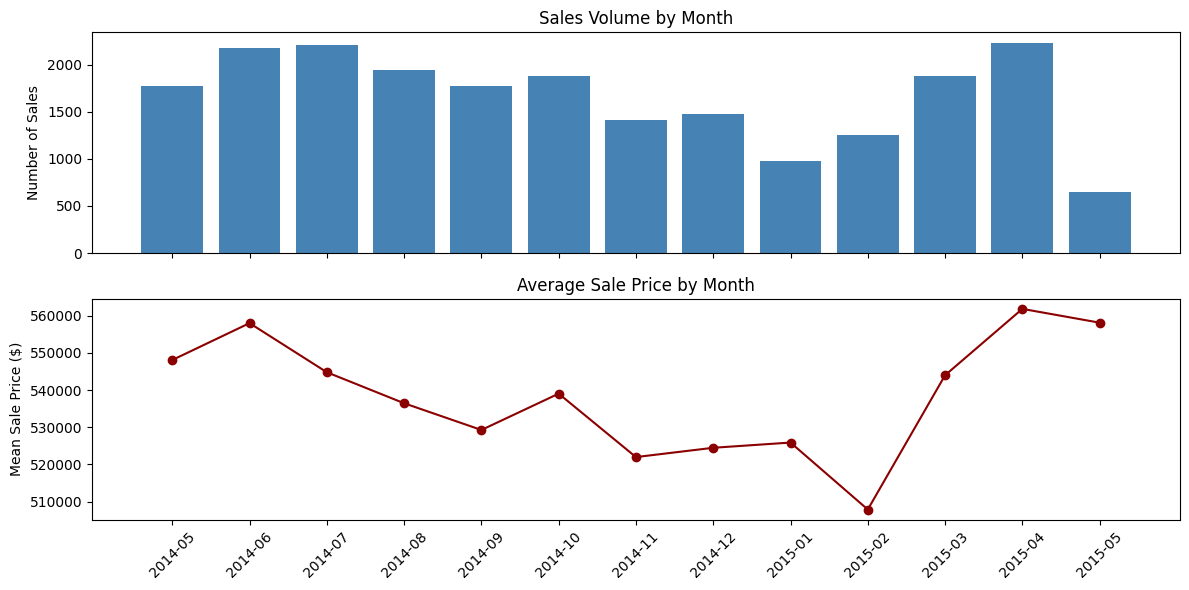

In [ ]:
# Visualize the temporal distribution of sales
df["year_month"] = df["date_parsed"].dt.to_period("M")
monthly_sales = df.groupby("year_month").agg(
    count=("price", "count"),
    mean_price=("price", "mean")
).reset_index()
monthly_sales["year_month"] = monthly_sales["year_month"].astype(str)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].bar(monthly_sales["year_month"], monthly_sales["count"], color="steelblue")
axes[0].set_ylabel("Number of Sales")
axes[0].set_title("Sales Volume by Month")

axes[1].plot(monthly_sales["year_month"], monthly_sales["mean_price"], 
             marker="o", color="darkred")
axes[1].set_ylabel("Mean Sale Price ($)")
axes[1].set_title("Average Sale Price by Month")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Observation**: There is a clear temporal pattern — prices vary over time. A model trained on "future" months would have an unfair advantage when predicting "past" months.

### 3.1 Visualizing the Leakage Problem

In [ ]:
# Demonstrate the difference between random and temporal splits
np.random.seed(42)

# Random split
train_random, test_random = train_test_split(df, test_size=0.2, random_state=42)

# Temporal split
df_sorted = df.sort_values("date_parsed")
split_idx = int(len(df_sorted) * 0.8)
train_temporal = df_sorted.iloc[:split_idx]
test_temporal = df_sorted.iloc[split_idx:]

print("RANDOM SPLIT:")
print(f"  Train dates: {train_random['date_parsed'].min().date()} to {train_random['date_parsed'].max().date()}")
print(f"  Test dates:  {test_random['date_parsed'].min().date()} to {test_random['date_parsed'].max().date()}")
print(f"  ⚠️  OVERLAP: Test set contains dates from the ENTIRE range!")

print("\nTEMPORAL SPLIT:")
print(f"  Train dates: {train_temporal['date_parsed'].min().date()} to {train_temporal['date_parsed'].max().date()}")
print(f"  Test dates:  {test_temporal['date_parsed'].min().date()} to {test_temporal['date_parsed'].max().date()}")
print(f"  ✓ NO OVERLAP: Test set contains only FUTURE dates.")

RANDOM SPLIT:
  Train dates: 2014-05-02 to 2015-05-24
  Test dates:  2014-05-02 to 2015-05-27
  ⚠️  OVERLAP: Test set contains dates from the ENTIRE range!

TEMPORAL SPLIT:
  Train dates: 2014-05-02 to 2015-03-10
  Test dates:  2015-03-10 to 2015-05-27
  ✓ NO OVERLAP: Test set contains only FUTURE dates.


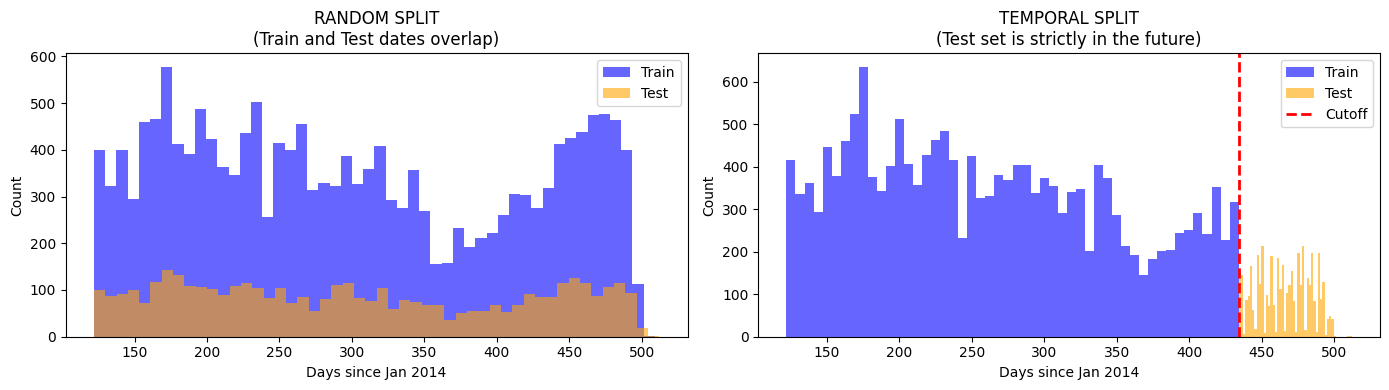

In [ ]:
# Visualize the splits
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Random split
axes[0].hist(train_random["date_parsed"].dt.dayofyear + 
             (train_random["date_parsed"].dt.year - 2014) * 365,
             bins=50, alpha=0.6, label="Train", color="blue")
axes[0].hist(test_random["date_parsed"].dt.dayofyear + 
             (test_random["date_parsed"].dt.year - 2014) * 365,
             bins=50, alpha=0.6, label="Test", color="orange")
axes[0].set_xlabel("Days since Jan 2014")
axes[0].set_ylabel("Count")
axes[0].set_title("RANDOM SPLIT\n(Train and Test dates overlap)")
axes[0].legend()

# Temporal split
axes[1].hist(train_temporal["date_parsed"].dt.dayofyear + 
             (train_temporal["date_parsed"].dt.year - 2014) * 365,
             bins=50, alpha=0.6, label="Train", color="blue")
axes[1].hist(test_temporal["date_parsed"].dt.dayofyear + 
             (test_temporal["date_parsed"].dt.year - 2014) * 365,
             bins=50, alpha=0.6, label="Test", color="orange")
axes[1].axvline(x=train_temporal["date_parsed"].max().dayofyear + 
                (train_temporal["date_parsed"].max().year - 2014) * 365,
                color="red", linestyle="--", linewidth=2, label="Cutoff")
axes[1].set_xlabel("Days since Jan 2014")
axes[1].set_ylabel("Count")
axes[1].set_title("TEMPORAL SPLIT\n(Test set is strictly in the future)")
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.2 Quantifying the Impact of Temporal Leakage

In [ ]:
# Prepare features (simple subset for demonstration)
feature_cols = ["sqft_living", "bedrooms", "bathrooms", "floors", 
                "waterfront", "view", "condition", "grade",
                "sqft_above", "sqft_basement", "yr_built", "lat", "long"]

def train_and_evaluate(train_df, test_df, feature_cols):
    """Train a RandomForest and return RMSE."""
    X_train = train_df[feature_cols]
    y_train = train_df["price"]
    X_test = test_df[feature_cols]
    y_test = test_df["price"]
    
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return root_mean_squared_error(y_test, y_pred)

# Evaluate with random split
rmse_random = train_and_evaluate(train_random, test_random, feature_cols)

# Evaluate with temporal split
rmse_temporal = train_and_evaluate(train_temporal, test_temporal, feature_cols)

print("Model Performance Comparison:")
print(f"  Random split RMSE:   ${rmse_random:,.0f}")
print(f"  Temporal split RMSE: ${rmse_temporal:,.0f}")
print(f"\n  Difference: ${rmse_temporal - rmse_random:,.0f} ({100*(rmse_temporal - rmse_random)/rmse_random:.1f}% worse with temporal split)")

Model Performance Comparison:
  Random split RMSE:   $148,673
  Temporal split RMSE: $142,677

  Difference: $-5,995 (-4.0% worse with temporal split)


**Interpretation**: The model performs **worse** with the temporal split. This is expected and **honest**:

- The random split performance is **artificially inflated** by temporal leakage
- The temporal split performance is a **realistic estimate** of how the model would perform on future data
- The difference represents the "free accuracy" the model was getting from peeking into the future

## 4. The Correct Approach: Temporal Split

### 4.1 Basic Temporal Split

The simplest approach: sort by date, take the first 80% for training, the last 20% for testing.

```python
df_sorted = df.sort_values('date')
split_idx = int(len(df_sorted) * 0.8)
train = df_sorted.iloc[:split_idx]
test = df_sorted.iloc[split_idx:]
```

### 4.2 Temporal Cross-Validation

For more robust evaluation, use **TimeSeriesSplit** from scikit-learn:

```python
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    # Each fold uses earlier data for training, later data for validation
```

This creates expanding training windows and sliding validation windows.

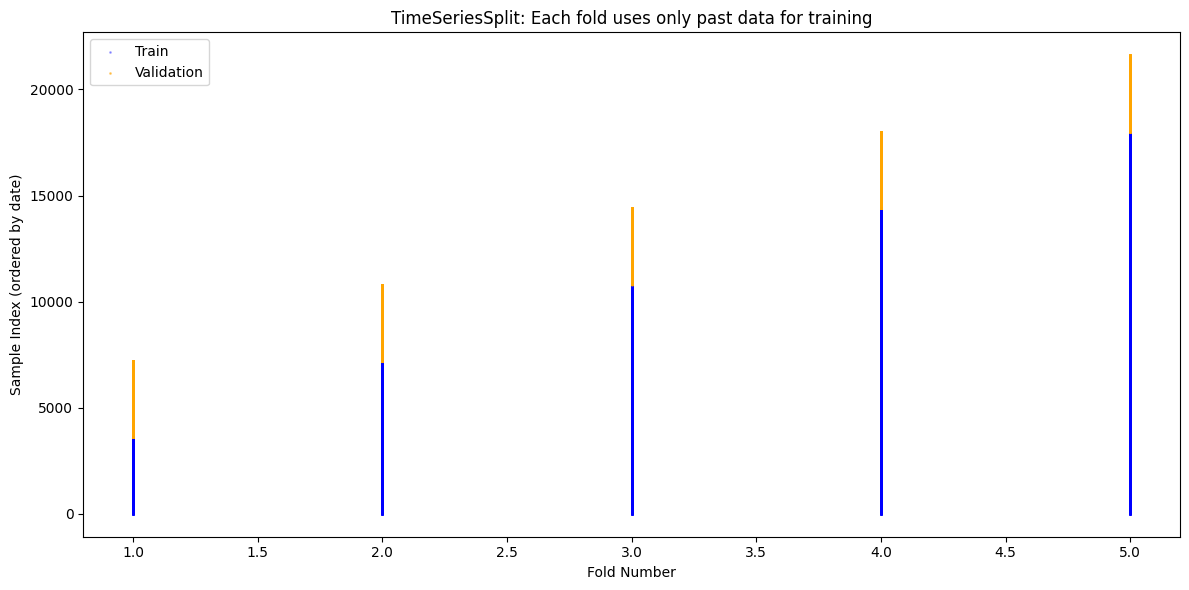

Note: In each fold, training data (blue) always comes BEFORE validation data (orange).


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Visualize TimeSeriesSplit folds
df_sorted = df.sort_values("date_parsed").reset_index(drop=True)
tscv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots(figsize=(12, 6))

for i, (train_idx, val_idx) in enumerate(tscv.split(df_sorted)):
    ax.scatter([i+1] * len(train_idx), train_idx, c='blue', alpha=0.3, s=1, label='Train' if i == 0 else '')
    ax.scatter([i+1] * len(val_idx), val_idx, c='orange', alpha=0.5, s=1, label='Validation' if i == 0 else '')

ax.set_xlabel('Fold Number')
ax.set_ylabel('Sample Index (ordered by date)')
ax.set_title('TimeSeriesSplit: Each fold uses only past data for training')
ax.legend()
plt.tight_layout()
plt.show()

print("Note: In each fold, training data (blue) always comes BEFORE validation data (orange).")

## 5. Model Selection Without Leakage

When comparing multiple models, we must also avoid **model selection leakage**:

### The Problem

If we use the same test set to:
1. Compare different models
2. Select the best model
3. Report final performance

...then we've implicitly optimized for that test set, and our reported performance is overly optimistic.

### The Solution: Three-Way Split

```
Data (sorted by time)
├── Training set (oldest) ────────► Fit models
├── Validation set (middle) ──────► Compare models, tune hyperparameters
└── Test set (newest) ────────────► Final evaluation (used ONCE)
```

The test set should be touched **only at the very end**, to get an unbiased estimate of production performance.

In [ ]:
def temporal_train_val_test_split(df, val_size=0.15, test_size=0.15):
    """
    Split data temporally into train, validation, and test sets.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataset with a 'date' or 'date_parsed' column.
    val_size : float
        Proportion for validation set.
    test_size : float
        Proportion for test set.
        
    Returns
    -------
    tuple: (train_df, val_df, test_df)
    """
    date_col = "date_parsed" if "date_parsed" in df.columns else "date"
    df_sorted = df.sort_values(date_col)
    
    n = len(df_sorted)
    train_end = int(n * (1 - val_size - test_size))
    val_end = int(n * (1 - test_size))
    
    train_df = df_sorted.iloc[:train_end]
    val_df = df_sorted.iloc[train_end:val_end]
    test_df = df_sorted.iloc[val_end:]
    
    return train_df, val_df, test_df

# Apply to our data
train, val, test = temporal_train_val_test_split(df, val_size=0.15, test_size=0.15)

print("Temporal Three-Way Split:")
print(f"  Train:      {len(train):,} records ({100*len(train)/len(df):.0f}%)")
print(f"              {train['date_parsed'].min().date()} to {train['date_parsed'].max().date()}")
print(f"  Validation: {len(val):,} records ({100*len(val)/len(df):.0f}%)")
print(f"              {val['date_parsed'].min().date()} to {val['date_parsed'].max().date()}")
print(f"  Test:       {len(test):,} records ({100*len(test)/len(df):.0f}%)")
print(f"              {test['date_parsed'].min().date()} to {test['date_parsed'].max().date()}")

Temporal Three-Way Split:
  Train:      15,129 records (70%)
              2014-05-02 to 2015-01-16
  Validation: 3,242 records (15%)
              2015-01-16 to 2015-03-26
  Test:       3,242 records (15%)
              2015-03-26 to 2015-05-27


## 6. When Is Temporal Split NOT Needed?

Temporal splits are essential when:
- **Time is a factor**: Prices, trends, or patterns change over time
- **Production use is forward-looking**: You'll train on historical data and predict future observations

Random splits might be acceptable when:
- **Data is i.i.d.**: Observations are truly independent and identically distributed
- **No temporal patterns**: The target doesn't depend on when the observation occurred
- **Cross-sectional prediction**: You're predicting across entities at a fixed point in time

**For real estate data**, temporal splits are almost always appropriate because:
- Markets evolve over time
- Economic conditions affect prices
- Seasonal patterns exist
- The goal is to predict future sale prices

## 7. Summary

### Key Concepts

| Concept | Definition |
|---------|------------|
| **Temporal leakage** | Using future information to train a model that predicts the past |
| **Temporal split** | Splitting data chronologically — train on past, test on future |
| **Model selection leakage** | Optimizing model choice using the test set |
| **Three-way split** | Train + Validation (for model selection) + Test (for final evaluation) |

### Best Practices

1. **Always examine date ranges** in your train and test sets
2. **Use temporal splits** for time-ordered data
3. **Reserve the test set** until final evaluation
4. **Use TimeSeriesSplit** for cross-validation on temporal data
5. **Expect lower test performance** than with random splits — this is honest, not a problem